# Contact maps
In this notebook we calculate the contact maps between two masks.

In [1]:
from traj_loading import load_Trajs_generator
import numpy as np
import mdtraj as md
from glob import glob
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

/Users/je714/anaconda/envs/md_analysis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/je714/anaconda/envs/md_analysis/lib/python3.4/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/je714/anaconda/envs/md_analysis/lib/python3.4/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/je714/anaconda/envs/md_analysis/lib/python3.4/site-packages/ipykernel/pylab/config.py:85:

Provide the topologies with glob expression.


Provide the matching topology as a string.

In [2]:
nc_file_list = sorted(glob(
        "/Users/je714/Troponin/IAN_Troponin/completehowarthcut/salted/ff14SB/run1/05*nc"))
topology = "/Users/je714/Troponin/IAN_Troponin/completehowarthcut/salted/ff14SB/run1/WT-ff14SB_clean.prmtop"

Provide two masks to check the contacts. 0 indexed residue ranges only.

We generate a residue-residue pair list with `itertools.product()`.

In [3]:
start1, end1 = 0, 88
start2, end2 = 248, 288
list1 = list(range(start1, end1 + 1))
list2 = list(range(start2, end2 + 1))
pairs = list(itertools.product(list1, list2))
print('Mask1 has %d residues\n' % (end1 - start1 + 1))
print('Mask2 has %d residues\n' % (end2 - start2 + 1))
print('Number of residue-residue interactions that will be considered: %d\n' % len(pairs))

Mask1 has 89 residues

Mask2 has 41 residues

Number of residue-residue interactions that will be considered: 3649



## Contact implementation using `md.compute_contacts`.

It only allows for three types of contact definition. It gives much higher values than cpptraj unless really low values of distance are used as a cutoff.

In [4]:
stride = 5
chunk = 100
trajs_generator= load_Trajs_generator(trajfiles_list=nc_file_list,
                                      prmtop_file=topology, stride=stride, chunk=chunk)
frequency = np.zeros((len(list1), len(list2)))
count = 0 # Keep the frame count

for traj_chunk in trajs_generator:
    count += traj_chunk.n_frames
    distances_inChunk = md.compute_contacts(traj_chunk, pairs, scheme = 'ca')
    column_sum = (distances_inChunk[0] <= 4).sum(0) # Sum by column
    frequency += column_sum.reshape(len(list1), len(list2)) # Sum the partial result to frequency

contact_frequency = frequency / count # Total contact value for each residue-residue pair. From 0 to 1.

print('Number of analyzed frames: %d\n' % count)
print('Aggregate simulation time: %2.f ns\n' % (count * 0.02 * stride))
print(contact_frequency)

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 422 residues, 6812 atoms, 6844 bonds> 

[   0    1    2 ..., 6809 6810 6811]
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 422 residues, 6812 atoms, 6844 bonds> 

[   0    1    2 ..., 6809 6810 6811]
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 422 residues, 6812 atoms, 6844 bonds> 

[   0    1    2 ..., 6809 6810 6811]
Number of analyzed frames: 2500

Aggregate simulation time: 250 ns

[[ 0.4776  0.4812  0.5424 ...,  1.      1.      1.    ]
 [ 0.5164  0.5608  0.6604 ...,  1.      1.      1.    ]
 [ 0.5228  0.572   0.6568 ...,  1.      1.      1.    ]
 ..., 
 [ 0.724   0.7236  0.7324 ...,  1.      1.      1.    ]
 [ 0.6448  0.6368  0.648  ...,  1.      1.      1.    ]
 [ 0.5284  0.5144  0.4896 ...,  1.      1.      1.    ]]


Let's try to make a heat map...

In [5]:
def plot_heatmap(array):
    plt.figure(figsize=(10,10), dpi=900)
    ax = sns.heatmap(contact_frequency,
                    vmin=0, vmax=1,
                    xticklabels=list2,
                    yticklabels=list1,
                    annot=False)
    ax.invert_yaxis()
    sns.plt.show()

/Users/je714/anaconda/envs/md_analysis/lib/python3.4/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/je714/anaconda/envs/md_analysis/lib/python3.4/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


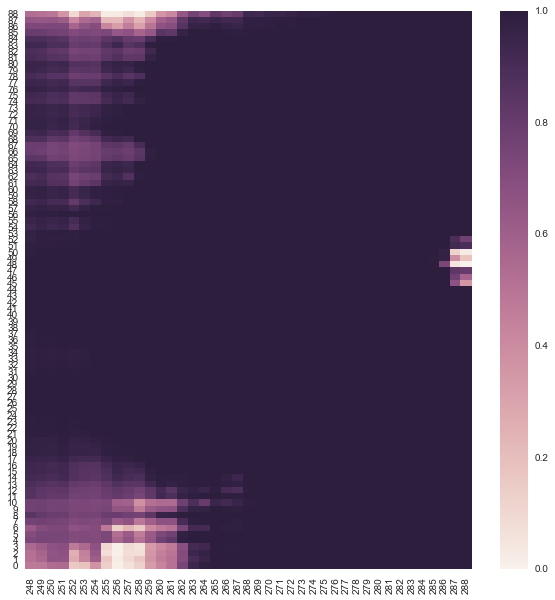

In [6]:
plot_heatmap(contact_frequency)

## Manual implementation of contacts
Let's try to define a contact as Cheng et al.[1](http://www.sciencedirect.com/science/article/pii/S0006349514008510), which in turn get the definition from Wang et al.[2](http://www.ncbi.nlm.nih.gov/pubmed/23454346).


"Contacts between residues were identified, where the distance between two carbon atoms was $\leq$ 5.4 Å or any other non-carbon atoms were $\leq$ 4.6 Å."

We begin by adding a Cartesian product implementation for two numpy arrays. Extracted from [StackOverflow](http://stackoverflow.com/questions/11144513/numpy-cartesian-product-of-x-and-y-array-points-into-single-array-of-2d-points). We'll use it when computing the pairwise atoms to check the distance for in each residue-residue pair.

In [ ]:
def cartesianProduct_npArrays(x,y):
    return(np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]))

In [ ]:
top = md.load_prmtop(topology)
stride = 5
chunk = 100
trajs_generator= load_Trajs_generator(trajfiles_list=nc_file_list,
                                      prmtop_file=topology, stride=stride, chunk=chunk)
frequency = np.zeros(len(pairs))
count = 0 # Keep the frame count
for traj_chunk in trajs_generator:
    count += traj_chunk.n_frames
    index=0 # To update the contact count for each residue-residue pair
    for residue_pair in pairs:
        # Atom selection for each residue in the pair
        c_atoms_residue1 = top.select("resid %d and (type C)" % residue_pair[0])
        not_c_atoms_residue1 = top.select("resid %d and not type C" % residue_pair[0])
        c_atoms_residue2 = top.select("resid %d and type C" % residue_pair[1])
        not_c_atoms_residue2 = top.select("resid %d and not type C" % residue_pair[1])
        
        # Calculate all the possible distances between the C-C atoms and the 
        # non C-C atoms. Results are stored in two np.arrays of shape:
        # (traj_chunk.n_frames, c_atoms_residue1*c_atoms_residue2)
        # (traj_chunk.n_frames, non_c_atoms_residue1*non_c_atoms_residue2)
        c_atoms_dist = md.compute_distances(traj_chunk,
                                            cartesianProduct_npArrays(c_atoms_residue1,
                                                                      c_atoms_residue2))
        not_c_atoms_dist = md.compute_distances(traj_chunk,
                                                cartesianProduct_npArrays(not_c_atoms_residue1,
                                                                          not_c_atoms_residue2))
        # Implementation of the contact condition
        if ((c_atoms_dist <= 5.4).sum(1).any() > 0) and ((not_c_atoms_dist <= 4.6).sum(1).any() > 0):
            frequency[index] += 1
        index += 1
contact_frequency = (frequency/count).reshape(len(list1), len(list2))
#        value = np.hstack((c_atoms_dist <= 5.4).sum(1))
#        print(value.shape)
plot_heatmap(contact_frequency)
            
        

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 422 residues, 6812 atoms, 6844 bonds> 

[   0    1    2 ..., 6809 6810 6811]


In [ ]:
top